<a href="https://colab.research.google.com/github/italomarcelogit/pytorch-sample-temporal/blob/main/PyTorch_Temporal_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install -q --no-deps yfinance
import yfinance as yf

In [27]:
import pandas as pd
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [28]:
petr = yf.Ticker('PETR4.SA')

In [29]:
petr.info['website'], petr.info['logo_url']
# petr.info # exibe todos os atributos

('https://petrobras.com.br', 'https://logo.clearbit.com/petrobras.com.br')

In [30]:
data = yf.download('PETR4.SA', start='2016-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [31]:
dados = data[data.index > '2021-12-31']
historico = data[data.index <= '2019-12-31']
dados.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,28.540001,29.219999,28.530001,29.090000,26.614141,52704700
2022-01-04,29.160000,29.400000,28.910000,29.200001,26.714779,51739200
2022-01-05,29.190001,29.270000,27.940001,28.070000,25.680954,78459800
2022-01-06,28.290001,28.650000,27.840000,28.049999,25.662655,61163100
2022-01-07,28.110001,28.290001,27.820000,28.180000,25.781591,47507600


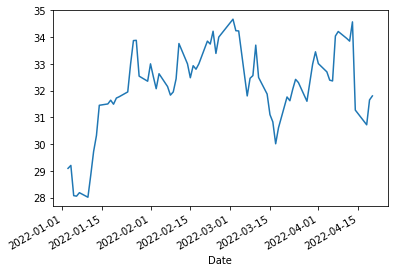

In [32]:
dados.Close.plot()

In [33]:
# from re import template
import plotly.graph_objects as go

fig = go.Figure()
eixox = historico.index.date

# Add traces
fig.add_trace(go.Scatter(x=eixox, y=historico.High.to_list(),
                    mode='lines+markers',
                    name='High'))
fig.add_trace(go.Scatter(x=eixox, y=historico.Close.to_list(),
                    mode='lines+markers',
                    name='Close'))
fig.update_layout(template='plotly_white', title='Histórico PETR4.SA', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()

In [34]:
historico = historico.Close

In [35]:
treino = historico[historico.index < '2019-01-01']
teste = historico[historico.index > '2018-12-31']

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=treino.index.date, y=treino.to_list(),
                    mode='lines+markers',
                    name='Close - Treino'))
fig.add_trace(go.Scatter(x=teste.index.date, y=teste.to_list(),
                    mode='lines+markers',
                    name='Close - Teste'))
fig.update_layout(template='plotly_white', title='Histórico PETR4.SA', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()

# **Pre Processamento**

**Criando janelas deslizantes**

In [36]:
janelas = 30 # janelas deslizantes e a qtd foi um chute

datafinal = np.zeros([historico.size - janelas, janelas +1])
for i in range(len(datafinal)):
  for j in range(janelas + 1):
    datafinal[i][j] = historico.iloc[i+j]
datafinal

array([[ 6.86999989,  6.67999983,  6.4000001 , ...,  4.44000006,
         4.67999983,  4.59000015],
       [ 6.67999983,  6.4000001 ,  6.26000023, ...,  4.67999983,
         4.59000015,  4.46000004],
       [ 6.4000001 ,  6.26000023,  6.26999998, ...,  4.59000015,
         4.46000004,  5.03999996],
       ...,
       [30.02000046, 30.45000076, 30.02000046, ..., 30.26000023,
        30.5       , 30.90999985],
       [30.45000076, 30.02000046, 29.89999962, ..., 30.5       ,
        30.90999985, 30.52000046],
       [30.02000046, 29.89999962, 29.29999924, ..., 30.90999985,
        30.52000046, 30.18000031]])

Observe que o segundo valor do primeiro array (janela 1), é o primeiro valor do segundo array (janela 2) e assim sucessivamente


**Normalizando os valores entre 0 e 1**

In [37]:
dif = datafinal.max() - datafinal.min()
datafinal = (datafinal - datafinal.min()) / dif
x = datafinal[:, :-1]
y = datafinal[:, -1]

In [38]:
x[:1], y[:1]

(array([[0.09973852, 0.09264102, 0.08218156, 0.07695183, 0.07732537,
         0.07060143, 0.0496825 , 0.03997012, 0.05565933, 0.0362346 ,
         0.02241316, 0.01718342, 0.00859171, 0.01120658, 0.0078446 ,
         0.        , 0.01382146, 0.0149421 , 0.02390737, 0.01942473,
         0.00373554, 0.01083302, 0.01979829, 0.01270079, 0.00410908,
         0.00112067, 0.00933881, 0.01382146, 0.00896527, 0.01793052]]),
 array([0.01456856]))

In [39]:
historico.shape, treino.shape, teste.shape

((997,), (749,), (248,))

**Convertendo p/ tensores**

In [40]:
posTreino = treino.shape[0]
posTreino

749

In [41]:
Xtreino = torch.FloatTensor(x[:posTreino, :])
ytreino = torch.FloatTensor(y[:posTreino])

In [42]:
Xtreino.size(), ytreino.size()

(torch.Size([749, 30]), torch.Size([749]))

In [43]:
Xtreino[:1]

tensor([[0.0997, 0.0926, 0.0822, 0.0770, 0.0773, 0.0706, 0.0497, 0.0400, 0.0557,
         0.0362, 0.0224, 0.0172, 0.0086, 0.0112, 0.0078, 0.0000, 0.0138, 0.0149,
         0.0239, 0.0194, 0.0037, 0.0108, 0.0198, 0.0127, 0.0041, 0.0011, 0.0093,
         0.0138, 0.0090, 0.0179]])

In [44]:
ytreino[:1]

tensor([0.0146])

In [45]:
Xteste = torch.FloatTensor(x[posTreino:, :])
yteste = torch.FloatTensor(y[posTreino:])
Xteste.size(), yteste.size()

(torch.Size([218, 30]), torch.Size([218]))

# **Treinando Rede Neural**

**Criando a classe e seus metodos**


In [46]:
class Net(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Net, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, 1)
  
  def forward(self, x):
    hidden = self.fc1(x)
    relu = self.relu(hidden)
    output = self.fc2(relu)
    output = self.relu(output)
    return output

**Construindo o modelo**

In [47]:
entrada = Xtreino.size()[1] # tamanho da janela
camada_escondida = 100 # chute
modelo = Net(entrada, camada_escondida)
modelo

Net(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

**Configurando critérios**

In [48]:
# critério de erro
criterium = torch.nn.MSELoss()
# parametros
lr = 0.09 # loss_rate ou lr 0.01 É OBRIGATÓRIO
momentum = 0.03 # 0.01 momentun
optim = torch.optim.SGD(modelo.parameters(), lr, momentum)

**Visualizando pesos**

In [49]:
# visualizar os pesos entre as camadas
for p in modelo.parameters():
  print(p)
  pass

Parameter containing:
tensor([[-0.1736, -0.0105,  0.1213,  ..., -0.1549,  0.0050, -0.0764],
        [-0.0662, -0.0280,  0.0572,  ...,  0.1620, -0.0560,  0.0771],
        [ 0.1289,  0.1698, -0.1485,  ...,  0.0860,  0.0661, -0.0050],
        ...,
        [ 0.1171, -0.0642,  0.0984,  ..., -0.0947, -0.1568,  0.1697],
        [-0.0426, -0.1724,  0.0513,  ...,  0.0118,  0.0208, -0.1559],
        [-0.1651, -0.1317, -0.0111,  ..., -0.1660, -0.1511,  0.0690]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0522, -0.0889,  0.0315,  0.1062,  0.0737,  0.1723, -0.0925, -0.0873,
         0.0721, -0.1721, -0.0178, -0.0609,  0.1042,  0.0826,  0.1152,  0.0620,
        -0.1478, -0.0263, -0.0975,  0.1413, -0.0121,  0.0092, -0.1707, -0.1266,
         0.0075, -0.0799,  0.0103, -0.0814, -0.1076,  0.1182, -0.0418,  0.0448,
        -0.0160,  0.1020, -0.0364, -0.0403,  0.0154, -0.0036, -0.1680, -0.1668,
         0.1388,  0.1159,  0.0597,  0.1630,  0.0624,  0.1584,  0.1627,  0.0493,
        -0.0762

**Treino**

In [50]:
modelo.train()
epochs = 70001
errors = []

for epoch in range(epochs):
  optim.zero_grad()
  ypred = modelo(Xtreino)
  loss = criterium(ypred.squeeze(), ytreino)
  errors.append(loss.item())
  if epoch % 10000 == 0:
    print(f'Epoch: {epoch}. Train Loss: {loss.item()}')
  loss.backward()
  optim.step()

Epoch: 0. Train Loss: 0.09961487352848053
Epoch: 10000. Train Loss: 0.0003709466545842588
Epoch: 20000. Train Loss: 0.0003345798177178949
Epoch: 30000. Train Loss: 0.0003325722645968199
Epoch: 40000. Train Loss: 0.000330643990309909
Epoch: 50000. Train Loss: 0.0003152774297632277
Epoch: 60000. Train Loss: 0.0003190229763276875
Epoch: 70000. Train Loss: 0.00030906565370969474


**Teste**

In [51]:
modelo.eval()
ypred = modelo(Xteste)
postreino = criterium(ypred.squeeze(), yteste)
print(f'Perda na base teste após treino: {postreino.item()}')

Perda na base teste após treino: 0.00036244382499717176


**Visualização  - Erros e Previsão**

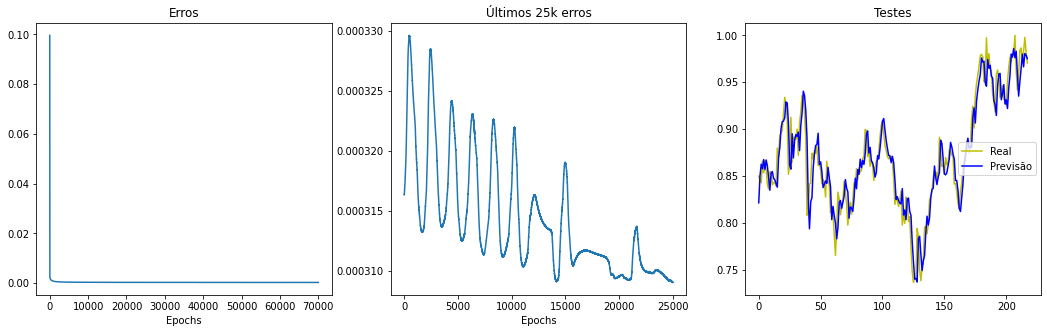

In [52]:
def grafico(errors):
  erros = np.array(errors)
  ultimosErros = np.array(erros[-25000:])
  plt.figure(figsize=(18, 5))
  g1 = plt.subplot(1, 3, 1)
  g1.set_title('Erros')
  plt.plot(erros, '-')
  plt.xlabel('Epochs')

  g2 = plt.subplot(1, 3, 2)
  g2.set_title('Últimos 25k erros')
  plt.plot(ultimosErros, '-')
  plt.xlabel('Epochs')

  g3 = plt.subplot(1, 3, 3)
  g3.set_title('Testes')
  plt.plot(yteste.numpy(), 'y-', label='Real')
  # plt.xlabels('Epochs')
  a = plt.plot(ypred.detach().numpy(), 'b-', label='Previsão')
  plt.legend(loc=7)
  plt.show()
grafico(errors)  

In [53]:
import itertools
dteste = yteste.numpy().tolist()
dpred = ypred.detach().numpy().tolist()
dpred = list(itertools.chain.from_iterable(dpred))

In [54]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x = teste.index.date, y=dteste,
                    mode='lines',
                    name='Dados Teste'))
fig.add_trace(go.Scatter(x = teste.index.date, y=dpred,
                    mode='lines+markers',
                    name='Dados Previsão - PETR4.SA'))
fig.update_layout(template='plotly_white', title='Detalhamento da previsão', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()

Aparentemente a rede trouxe um resultado a um dia posterior. então, voltarei os dados um dia

In [55]:
roll = torch.roll(ypred, -1, 0)
roll[-1] = roll[-2]

In [56]:

dpred = roll.detach().numpy().tolist()
dpred = list(itertools.chain.from_iterable(dpred))

In [57]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x = teste.index.date, y=dteste,
                    mode='lines',
                    name='Dados Teste'))
fig.add_trace(go.Scatter(x = teste.index.date, y=dpred,
                    mode='lines+markers',
                    name='Dados Previsão - PETR4.SA'))
fig.update_layout(template='plotly_white', title='Detalhamento da previsão', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()

# **Prevendo 2022**

In [58]:
dados2022 = np.zeros([dados.Close.size - janelas, janelas +1])
for i in range(len(dados2022)):
  for j in range(janelas + 1):
    dados2022[i][j] = dados.Close.iloc[i+j]

dif = dados2022.max() - dados2022.min()
dados2022 = (dados2022 - dados2022.min()) / dif
x = dados2022[:, :-1]
y = dados2022[:, -1]



In [59]:
Xteste2022 = torch.FloatTensor(x)
yteste2022 = torch.FloatTensor(y)
Xteste2022.size(), yteste2022.size()

(torch.Size([45, 30]), torch.Size([45]))

In [60]:
modelo.eval()
ypred2022 = modelo(Xteste2022)
postreino2022 = criterium(ypred2022.squeeze(), yteste2022)
print(f'Perda na base teste após treino: {postreino2022.item()}')

Perda na base teste após treino: 0.019162103533744812


In [61]:
dteste2022 = yteste2022.numpy().tolist()
dpred2022 = ypred2022.detach().numpy().tolist()
dpred2022 = list(itertools.chain.from_iterable(dpred2022))

In [62]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x = dados.index.date, y=dteste2022,
                    mode='lines',
                    name='Dados Teste'))
fig.add_trace(go.Scatter(x = dados.index.date, y=dpred2022,
                    mode='lines+markers',
                    name='Dados Previsão - PETR4.SA'))
fig.update_layout(template='plotly_white', title='Detalhamento da previsão', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()

In [63]:
roll = torch.roll(ypred2022, -1, 0)
roll[-1] = roll[-2]

In [64]:
dpred2022 = roll.detach().numpy().tolist()
dpred2022 = list(itertools.chain.from_iterable(dpred2022))

In [65]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x = dados.index.date, y=dteste2022,
                    mode='lines',
                    name='Dados Reais'))
fig.add_trace(go.Scatter(x = dados.index.date, y=dpred2022,
                    mode='lines+markers',
                    name='Dados Previsto - Total'))
fig.update_layout(template='plotly_white', title='Detalhamento da previsão', 
                  xaxis_title='Data', xaxis_type='category',
                  yaxis_title='Valor',
                  )
fig.show()